In [14]:
!pip install xgboost


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
# Step 1: Import libraries
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

# Step 2: Load the saved training and testing data
train_data = pd.read_csv("train_multi_output.csv")
test_data = pd.read_csv("test_multi_output.csv")

# Step 3: Separate features (X) and target variables (y)
X_train = train_data[['Season', 'Day_of_the_week', 'DHI', 'DNI', 'GHI', 'Wind_speed', 'Humidity', 'Temperature']]
y_train = train_data[['PV_production', 'Wind_production']]

X_test = test_data[['Season', 'Day_of_the_week', 'DHI', 'DNI', 'GHI', 'Wind_speed', 'Humidity', 'Temperature']]
y_test = test_data[['PV_production', 'Wind_production']] 

In [16]:
# ----- Linear Regression -----
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluation
mae_pv_lr = mean_absolute_error(y_test['PV_production'], y_pred_lr[:, 0])
mae_wind_lr = mean_absolute_error(y_test['Wind_production'], y_pred_lr[:, 1])
rmse_pv_lr = np.sqrt(mean_squared_error(y_test['PV_production'], y_pred_lr[:, 0]))
rmse_wind_lr = np.sqrt(mean_squared_error(y_test['Wind_production'], y_pred_lr[:, 1]))
r2_pv_lr = r2_score(y_test['PV_production'], y_pred_lr[:, 0])
r2_wind_lr = r2_score(y_test['Wind_production'], y_pred_lr[:, 1])

print("----- Linear Regression Results -----")
print(f"PV -> MAE: {mae_pv_lr:.2f}, RMSE: {rmse_pv_lr:.2f}, R²: {r2_pv_lr:.3f}")
print(f"Wind -> MAE: {mae_wind_lr:.2f}, RMSE: {rmse_wind_lr:.2f}, R²: {r2_wind_lr:.3f}")

----- Linear Regression Results -----
PV -> MAE: 0.07, RMSE: 0.10, R²: 0.903
Wind -> MAE: 0.13, RMSE: 0.16, R²: 0.481


In [17]:
# Step 5: Initialize and train the XGBoost model
xgb_base = XGBRegressor(
    n_estimators=300,       # number of trees
    learning_rate=0.05,     # smaller = more precise
    max_depth=6,            # depth of each tree
    subsample=0.8,          # use 80% of data per tree
    colsample_bytree=0.8,   # use 80% of features per tree
    random_state=42,
    objective='reg:squarederror'
)

xgb_model = MultiOutputRegressor(xgb_base)
xgb_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None, ...))

In [ ]:
# Step 6: Predict on test data
y_pred = xgb_model.predict(X_test)

# Step 7: Evaluate each output separately

# For PV Production
mae_pv = mean_absolute_error(y_test['PV_production'], y_pred[:, 0])
mse_pv = mean_squared_error(y_test['PV_production'], y_pred[:, 0])
rmse_pv = np.sqrt(mse_pv)
r2_pv = r2_score(y_test['PV_production'], y_pred[:, 0])

# Calculate Adjusted R² for PV Production
n_pv = len(y_test['PV_production'])  # number of data points
p_pv = X_train.shape[1]  # number of features
adjusted_r2_pv = 1 - ((1 - r2_pv) * (n_pv - 1)) / (n_pv - p_pv - 1)

# For Wind Production
mae_wind = mean_absolute_error(y_test['Wind_production'], y_pred[:, 1])
mse_wind = mean_squared_error(y_test['Wind_production'], y_pred[:, 1])
rmse_wind = np.sqrt(mse_wind)
r2_wind = r2_score(y_test['Wind_production'], y_pred[:, 1])

# Calculate Adjusted R² for Wind Production
n_wind = len(y_test['Wind_production'])  # number of data points
p_wind = X_train.shape[1]  # number of features
adjusted_r2_wind = 1 - ((1 - r2_wind) * (n_wind - 1)) / (n_wind - p_wind - 1)

# Step 8: Print Results
print("----- XGBoost Results -----")
print(f"PV Production -> MAE: {mae_pv:.3f}, MSE: {mse_pv:.3f}, RMSE: {rmse_pv:.3f}, R²: {r2_pv:.3f}, Adjusted R²: {adjusted_r2_pv:.3f}")
print(f"Wind Production -> MAE: {mae_wind:.3f}, MSE: {mse_wind:.3f}, RMSE: {rmse_wind:.3f}, R²: {r2_wind:.3f}, Adjusted R²: {adjusted_r2_wind:.3f}")

----- XGBoost Results -----
PV Production -> MAE: 0.028, MSE: 0.003, RMSE: 0.056, R²: 0.971, Adjusted R²: 0.971
Wind Production -> MAE: 0.068, MSE: 0.009, RMSE: 0.093, R²: 0.834, Adjusted R²: 0.834


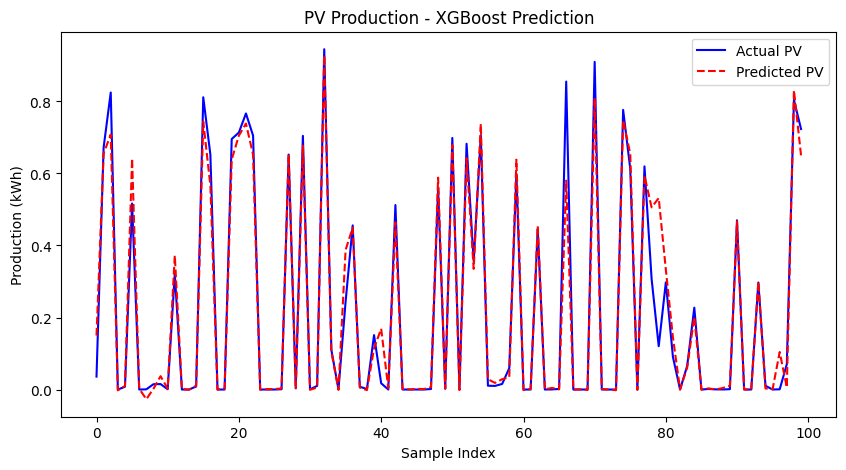

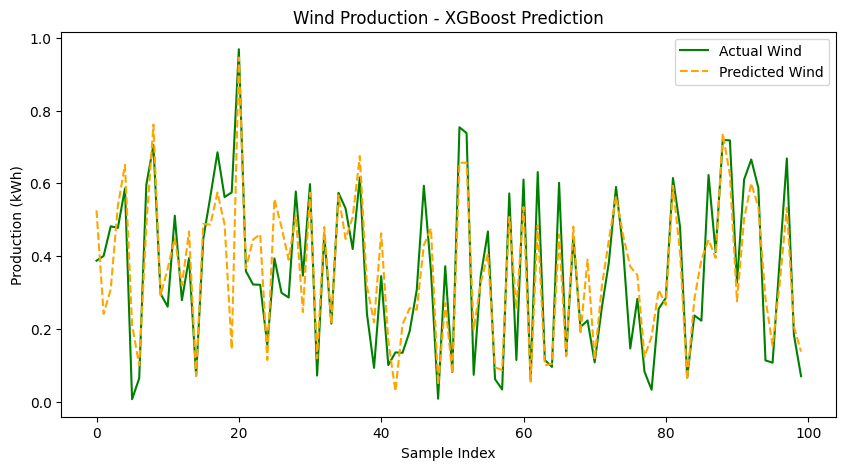

In [19]:
# PV Prediction Plot
plt.figure(figsize=(10,5))
plt.plot(y_test['PV_production'].values[:100], label='Actual PV', color='blue')
plt.plot(y_pred[:100, 0], label='Predicted PV', linestyle='--', color='red')
plt.title('PV Production - XGBoost Prediction')
plt.xlabel('Sample Index')
plt.ylabel('Production (kWh)')
plt.legend()
plt.show()

# Wind Prediction Plot
plt.figure(figsize=(10,5))
plt.plot(y_test['Wind_production'].values[:100], label='Actual Wind', color='green')
plt.plot(y_pred[:100, 1], label='Predicted Wind', linestyle='--', color='orange')
plt.title('Wind Production - XGBoost Prediction')
plt.xlabel('Sample Index')
plt.ylabel('Production (kWh)')
plt.legend()
plt.show()

           Feature  Importance
4              GHI    0.702905
3              DNI    0.116797
2              DHI    0.075219
6         Humidity    0.040079
0           Season    0.022650
7      Temperature    0.020226
5       Wind_speed    0.011783
1  Day_of_the_week    0.010342


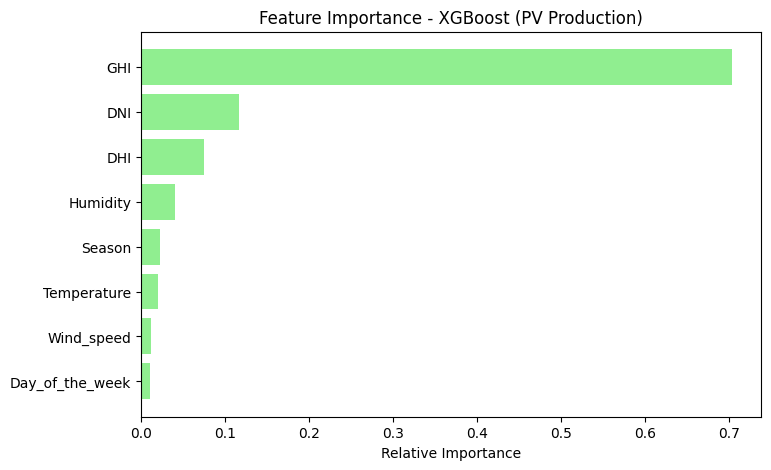

In [20]:
# Feature importance for one model (PV or Wind)
importances = xgb_model.estimators_[0].feature_importances_  # First model (PV)
features = X_train.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot importance
plt.figure(figsize=(8,5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='lightgreen')
plt.gca().invert_yaxis()
plt.title('Feature Importance - XGBoost (PV Production)')
plt.xlabel('Relative Importance')
plt.show()